## Importing area

In [302]:
import civil_war_base as cw
import pandas as pd
import timeit
from itertools import compress
from country_converter import CountryConverter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import timedelta  
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Forecasting civil wars
The aim of this project is to determine the causes that start a civil war to make predictions to avoid future conflicts. It will use monthly aggregations of events to predict the starting, ongoingness and ending of a conflict for the next month. Although most studies focus on theory, this project’s approach will follow recent studies using event data.

A python file called **"civil_war_base.py"** was created. It contains all the functions used in this notebook. For more information about the functions, please look them up in this file since they all contain docstrings with information. 

# 1. About the data

## 1.1. Integrated Crisis Early Warning System 
The Integrated Crisis Early Warning System ([ICEWS](https://en.wikipedia.org/wiki/Integrated_Conflict_Early_Warning_System))is a repository that contains counts of daily events worldwide. The data is currently stored in the [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/28075) along with information about its content. This project uses version 29.0, with events from 1995 to April 2020. All the files are provided in the file **events.zip** in the same repository as this notebook. The file was uploaded using [Git Large File Storage](https://git-lfs.github.com/) due to its size. 

The ICEWS dataset records the "who did what to whom and where" for events across the globe. 

To simplify the description of the data, the year 2017 is used in the following. 

In [2]:
year_2017 = cw.read_events_year("events.zip",2017)
year_2017.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,Target Country,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude
207243,27497746,4/20/2017,Basuki Tjahaja Purnama,"Provincial,Local,Government",Indonesia,Praise or endorse,51,3.4,Anies Baswedan,"Executive,Government,Education Ministry",Indonesia,44047601.0,3.0,The New York Times,Jakarta,NaN,Daerah Khusus Ibukota Jakarta,Indonesia,-6.21462,NaN
144136,27385039,3/21/2017,Hungary,NaN,Hungary,Consult,40,1.0,Latvia,NaN,Latvia,43780468.0,4.0,Baltic Daily,Riga,NaN,Riga,Latvia,56.94600,24.1059
213810,27509181,4/23/2017,Senate (Nigeria),"Upper House,Legislative / Parliamentary,Govern...",Nigeria,Make an appeal or request,20,3.0,Head of Government (Nigeria),"Executive,Executive Office,Government",Nigeria,44074311.0,6.0,Unknown,Magu,NaN,Kogi State,Nigeria,7.48330,NaN
33038,25389569,1/22/2017,Communist Party (China),"Communist,Parties,Ideological",China,Reduce relations,160,-4.0,City Mayor (China),"Government,Municipal,Local",China,43277942.0,5.0,Associated Press Newswires,Tianjin,NaN,Tianjin Shi,China,39.14220,NaN
581569,28144286,10/19/2017,Director General (South Korea),Government,South Korea,Express intent to meet or negotiate,36,4.0,Russia,NaN,Russian Federation,45604969.0,1.0,Unknown,Moscow,NaN,Moskva,Russian Federation,NaN,37.6156


The table above shows some rows from the 2017 ICEWS dataset. 

### 1.1.1. Conflict and Mediation Event Observations
The Conflict and Mediation Event Observations code (CAMEO code) is a coding system for event data.  There are 20 different codes for 20 different types of events and each has different levels of subcoding. The document containing information about each code can be downloaded from the [Harvard Dataverse](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/28075/SCJPXX&version=30.0) too. 

### 1.1.2. Intensity 
The intensity value derives from teh CAMEO code. It ranges from -10 to 10, with -10 representing the most hostile events and 10 the most cooperative events. 

### 1.1.3. Cleaning the data
For the purpose of this project, it is necessary to clean the data. The cleaning process goes like this:

   **1. Select events where "Source Country" is the same as "Target Country"**: To consider only internal events that may suggest internal conflict. 
   
   A column named "Year_Month" was added to store the year and the month of the event. 

In [3]:
year_2017_internal = cw.internal_events_year("events.zip",2017)
year_2017_internal.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,...,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude,Year_Month
630384,28227560,2017-11-11,Finance / Economy / Commerce / Trade Ministry ...,"Executive,Finance / Economy / Commerce / Trade...",Canada,Criticize or denounce,111,-2.0,Justin Trudeau,"(National) Major Party,Parties,Executive,Legis...",...,45800904.0,6.0,Daily Telegraph,NaN,NaN,NaN,Canada,45.4112,NaN,2017-11
695158,28335081,2017-12-12,Police (South Korea),"Government,Police",South Korea,Physically assault,182,-9.5,Citizen (South Korea),"Social,General Population / Civilian / Social",...,46059022.0,3.0,Yonhap English News,Jeonju,NaN,Jeollabuk-do,South Korea,35.8219,NaN,2017-12
380584,27796272,2017-07-08,Anton Siluanov,"Executive,Finance / Economy / Commerce / Trade...",Russian Federation,Make statement,10,0.0,Treasury/Finance Ministry (Russia),"Executive,Finance / Economy / Commerce / Trade...",...,44749791.0,4.0,Interfax News Service,Hamburg,NaN,Free and Hanseatic City of Hamburg,Germany,NaN,10.01530,2017-07
425658,27873663,2017-07-31,Police (Spain),"Police,Government",Spain,Investigate,90,-2.0,Government (Spain),Government,...,44941771.0,6.0,Reuters News,NaN,NaN,Catalunya,Spain,NaN,1.86768,2017-07
180889,27452920,2017-04-07,South Africa,NaN,South Africa,Demand change in leadership,1041,-5.0,Jacob Gedleyihlekisa Zuma,"Government,Elite,Ideological,Executive Office,...",...,43945512.0,1.0,Agence France-Presse,NaN,NaN,NaN,South Africa,-25.7449,NaN,2017-04


**2. Simply sectors mapping them**: Four sectors will be considered: Government (Gov), Insurgents (Ins), Opposition (Opp) and People (Peo). This will simplify the model and improve its interpretability. 

To map "Source/Target Name/Sectors" column a list of possible descriptions for each sector was used.  If the name of the country was in any of the "Source/Target Name/Sectors" columns, the sector was identified as Government.

In [4]:
year_2017_filtered = cw.read_filtered_data("events.zip",2017)
year_2017_filtered.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,...,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude,Year_Month
172944,27436708,2017-04-04,Congress of South African Trade Unions,Opp,South Africa,Appeal for change in leadership,241,-0.3,Jacob Gedleyihlekisa Zuma,Gov,...,43910978.0,1.0,Indo-Asian News Service,Johannesburg,City of Johannesburg Metropolitan Municipality,Gauteng,South Africa,-26.2023,NaN,2017-04
575248,28134033,2017-10-16,Afghanistan,Gov,Afghanistan,Mediate,45,5.0,Taliban,Ins,...,45581286.0,3.0,Indo-Asian News Service,Muscat,NaN,Muhafazat Masqat,Oman,NaN,58.5922,2017-10
37134,25397787,2017-01-24,China,Gov,China,Make an appeal or request,20,3.0,Religion (China),Gov,...,43299263.0,1.0,Xinhua News Agency,Beijing,NaN,Beijing Shi,China,39.9075,116.3970,2017-01
238318,27552113,2017-05-04,Ashraf Ghani Ahmadzai,Gov,Afghanistan,Make optimistic comment,13,0.4,Citizen (Afghanistan),Peo,...,44175725.0,4.0,Associated Press Newswires,Kabul,NaN,Kabul,Afghanistan,NaN,69.1723,2017-05
626031,28219581,2017-11-09,Health Ministry (Australia),Gov,Australia,Make statement,10,0.0,Tim Nicholls,Gov,...,45784071.0,4.0,Unknown,Toowoomba,Toowoomba,State of Queensland,Australia,-27.5606,NaN,2017-11


**3. Remove irrelevant columns**: Only "Country", "Source Sectors" (renamed as "Source"), "CAMEO", "Intensity", "Target Sector" (renamed as "Target") and "Year_Month" will be considered. 

In [5]:
year_2017_cols = cw.read_cols_filtered("events.zip",2017)
year_2017_cols.sample(5)

,Country,Source,CAMEO,Intensity,Target,Year_Month
160119,Philippines,Gov,173,-5.0,Ins,2017-03
542562,India,Gov,36,4.0,Peo,2017-09
286625,India,Gov,32,4.5,Opp,2017-05
98076,India,Gov,173,-5.0,Peo,2017-02
727987,Iraq,Peo,180,-9.0,Ins,2017-12


**4. Dummy variables of interaction**: A column for each Source_Target interaction will be generated (Gov_Opp, Peo_Ins, Ins_Gov,...) containing 1 if the event happens between the column sectors and 0 if not.  

This dummy encoding of the interaction will be helpful when building the models, when aggregating by “Year_Month” and “Country”, allowing means and counts of each type of interaction.

In [6]:
year_2017_final = cw.source_target_interaction("events.zip",2017)
year_2017_final.sample(5)

,Country,CAMEO,Intensity,Year_Month,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
328741,India,173,-5.0,2017-06,0,0,1,0,0,0,0,0,0,0,0,0
231742,India,10,0.0,2017-05,1,0,0,0,0,0,0,0,0,0,0,0
386173,China,10,0.0,2017-07,0,0,0,0,0,0,0,0,0,0,0,1
381402,India,40,1.0,2017-07,0,0,0,0,0,0,1,0,0,0,0,0
317894,India,173,-5.0,2017-06,0,0,1,0,0,0,0,0,0,0,0,0


**5. Adding ISO3 country code**: To avoid double counting a country (for example, North Korea and Republic of Korea) the ISO3 country code will be added. 

In [7]:
year_2017_iso3 = cw.iso3country("events.zip",2017)
year_2017_iso3.sample(5)

,Country,ISO3,Year_Month,CAMEO,Intensity,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
308742,Liberia,LBR,2017-06,20,3.0,0,1,0,0,0,0,0,0,0,0,0,0
707465,Somalia,SOM,2017-12,193,-10.0,0,0,1,0,0,0,0,0,0,0,0,0
62776,Egypt,EGY,2017-02,173,-5.0,0,0,1,0,0,0,0,0,0,0,0,0
643810,Croatia,HRV,2017-11,10,0.0,0,0,0,0,0,0,1,0,0,0,0,0
7621,India,IND,2017-01,90,-2.0,0,0,1,0,0,0,0,0,0,0,0,0


To see all events considered, a file called "all_events.csv" was created:

As a final note, only about 25% of the original data was used for the models:

In [8]:
len(year_2017_iso3)/len(year_2017)

0.2554110833678221

# 1.2. Political Instability Task Force

The State Failure Problem dataset will be used to stablish the start and ending of a civil war. This dataset comes from the Political Instability Task Force ([PITF](https://en.wikipedia.org/wiki/Political_Instability_Task_Force)), which is an American project that focuses on collecting data of political conflicts and state failure. The dataset can be found on the Center of Systemic Peace [webiste](http://www.systemicpeace.org/inscrdata.html) as the [Cosolidated Cases](http://www.systemicpeace.org/inscr/PITF%20Consolidated%20Case%20List%202018.pdf) dataset. The PITF criteria to determine a civil war can be found in its [Codebook](http://www.systemicpeace.org/inscr/PITFProbSetCodebook2018.pdf). This dataset containg civil wars from 1955 to 2018. 

## 1.2.1. Cleaning the data
The original data is presented in a PDF an was converted to a **.xlsx** using a [PDF to Excel Converter](https://smallpdf.com/pdf-to-excel). The returned file contains errors. A function that reads and fixes the data was defined <code>read_PITF()</code>:

In [9]:
PITF = cw.read_PITF("PITF Consolidated Case List 2018-converted.xlsx")
PITF.sample(5)

,ISO3,Year_Month_S,Year_Month_F
165,YEM,2004-06,2018-12
104,MEX,2007-05,2018-12
56,ETH,1999-02,2000-06
23,KHM,1997-07,1997-07
68,GNB,1998-06,2003-09


# 2. Data analysis and model building
Since the project is using monthly aggregations of events, the target variable will be a categorical one, with 4 categories: 000 (No civil war), 001 (Civil war ongoing), 010 (Civil war ending) and 100 (Civil war starting). This encoding will allow to see differences between cases more easier. For each row, the code will represent what will happen in the next month. 

Some countries do not register events for certain months. In that case, the values for each column in the missing "Year_Month" value will be filled with 0s.

To determine those difference, t-tests will be applied between cases where no civil war is taking place (000) and cases were a civil war is starting (100). This will allow to see if there is any particular difference between cases. For ongoingness (001) and ending (010) of the civil war, t-test will be used to determine differences between those cases. We will consider statistical significan for any value bellow 0.05. 

Principal component analysis will be applied on each model to look at data distributions and to see how well the model separates the data between cases. 

Finally, data will be modeled with random forests. Random forests are chosen as model because they can handle outliers and noise better than the other models. They are also good at reducing overfitting, which is ideal for the imbalanced data of this project. To meassure the model performance, the area under the receiving operating characteristic curve score (ROC AUC score) for each class will be used. 

One important thing to notice is the difference in the amount of data for each month between 1995 and 2018:

In [10]:
all_events = pd.read_csv("all_events.csv", low_memory = False)
all_events["Year_Month"] = pd.to_datetime(all_events["Year_Month"])

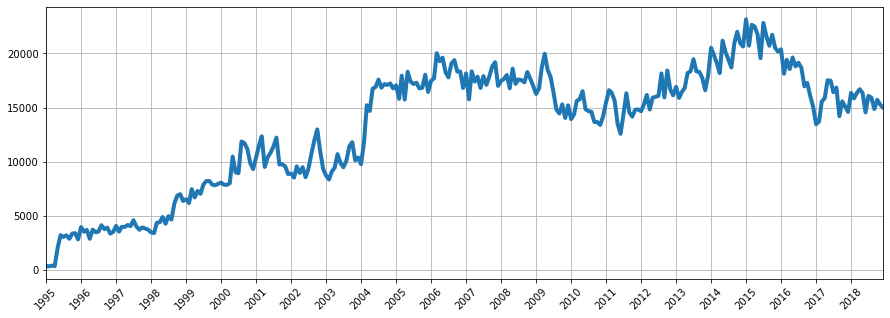

In [11]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(all_events["Year_Month"].value_counts().sort_index(), linewidth=4)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.grid()
plt.xticks(rotation=45);
plt.autoscale(enable=True, axis='x', tight=True)
plt.rcParams.update({'font.size': 22})

The ammount of data in each month varies during time. Models that rely on counts can not be used, since this differences may bias the results. Relative (fraction of the total) or average models will be used to avoid this. 

For training porpuses, the model will be trained from 2004 onwards, and the rest of the data will be used as a test set. Validation will be performed using out of bag samples. 

## 2.1. Interaction fraction model
The interaction fraction model records the fraction of the total interactions that occured for each interaction pair. For example, looking at data from 2017:

In [12]:
year_2017_iso3.drop(["Country","Intensity"], axis = 1).groupby(["ISO3","Year_Month"]).sum().head(1)

,,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
ISO3,Year_Month,,,,,,,,,,,,
AFG,2017-01,71.0,3.0,59.0,81.0,1.0,54.0,6.0,1.0,2.0,42.0,16.0,2.0


Each column represents the total number of events where each pair of sectors took part. The country is Afghanistan, January 2017. That month 338 internal events were registered. The fraction of events for each interaction pair is the number of events registered for that pair divided by the total number of events:

In [13]:
year_2017_iso3.drop(["Country","Intensity"], axis=1).groupby(["ISO3","Year_Month"]).sum().head(1)/338

,,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
ISO3,Year_Month,,,,,,,,,,,,
AFG,2017-01,0.210059,0.008876,0.174556,0.239645,0.002959,0.159763,0.017751,0.002959,0.005917,0.12426,0.047337,0.005917


This way all values are between 0 and 1 and countries were less events are registered do not bias the model. 

The model is generated using the function <code>interaction_fraction</code>, since it takes way too long to run, it has already been saved as a *.csv* file. 

In [14]:
interaction_fraction = pd.read_csv("interaction_fraction_model.csv", converters = {"CW_plus1" : str})
interaction_fraction = interaction_fraction.drop("Unnamed: 0", axis = 1)
interaction_fraction["Year_Month"] = pd.to_datetime(interaction_fraction["Year_Month"]).dt.to_period('M')

In [15]:
interaction_fraction.sample(5)

,ISO3,Year_Month,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,...,Peo_Gov,Peo_Ins,Peo_Opp,CW_s,CW_f,CW_o,CW_s_plus1,CW_f_plus1,CW_o_plus1,CW_plus1
65178,VAT,2002-07,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0,000
37842,MAR,2004-07,0.5,0.0,0.357143,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.0,0.0,0.0,0.0,0.0,0,0,0,000
14533,CXR,2006-02,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0,000
9620,CAF,2004-09,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.0,0.0,0.0,0.0,1.0,0,0,1,001
10697,CHL,1998-06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0,0,0,000


The predcitors have the following distributions:

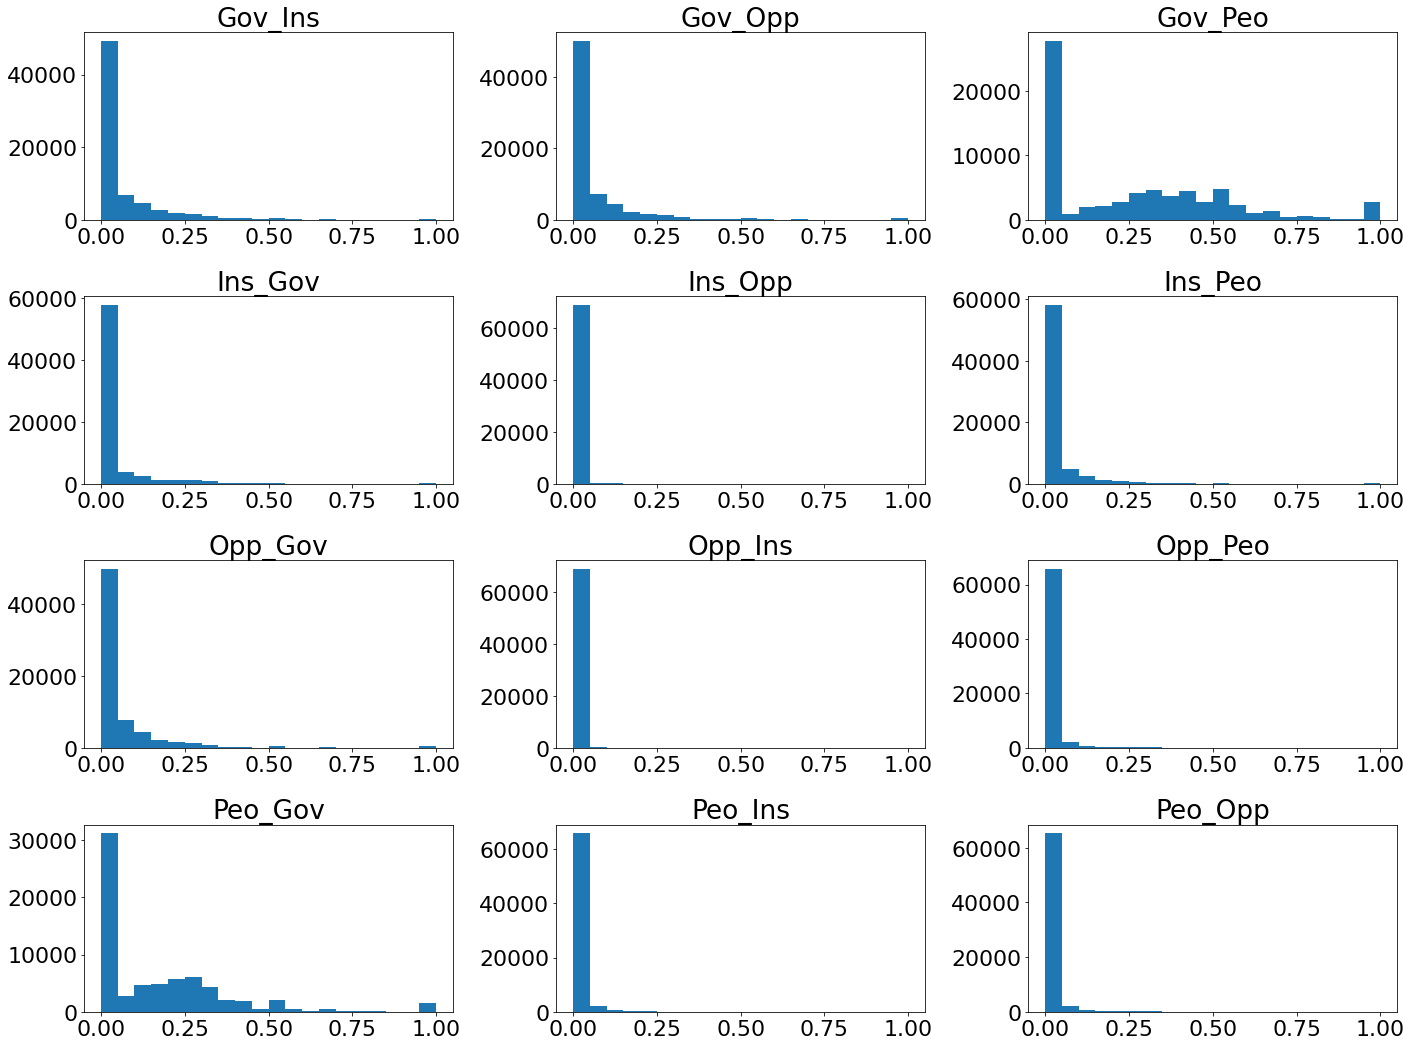

In [39]:
fig, axes = plt.subplots(ncols = 3, nrows = 4, figsize = (20,15))
cols_loop = [["Gov_Ins", "Gov_Opp", "Gov_Peo"], ["Ins_Gov", "Ins_Opp", "Ins_Peo"], 
           ["Opp_Gov", "Opp_Ins", "Opp_Peo"], ["Peo_Gov", "Peo_Ins", "Peo_Opp"]]
for i in range(0, 4):
    for j in range(0,3):
        axes[i,j].hist(interaction_fraction[cols_loop[i][j]], bins = 20)
        axes[i,j].set_title(cols_loop[i][j])
fig.tight_layout()

Most of the plots are very left skewed, while others present bimodal distributions. This is due to monthly aggregations where no events were registered at all. To improve the model, entries where the sum of the predictors is 0 (it should be 1, since they represent a fraction) will be removed (code suggested by [U2EF1](https://stackoverflow.com/questions/22649693/drop-rows-with-all-zeros-in-pandas-data-frame)):

In [34]:
model_filtered = interaction_fraction[(interaction_fraction[cols].T != 0).any()]
model_filtered.sample(5)

,ISO3,Year_Month,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,...,Peo_Gov,Peo_Ins,Peo_Opp,CW_s,CW_f,CW_o,CW_s_plus1,CW_f_plus1,CW_o_plus1,CW_plus1
21712,GEO,2004-05,0.130719,0.042484,0.294118,0.137255,0.006536,0.045752,0.049020,0.0,...,0.238562,0.035948,0.009804,0.0,0.0,0.0,0,0,0,000
29426,IRQ,1999-03,0.076923,0.051282,0.282051,0.153846,0.000000,0.025641,0.076923,0.0,...,0.333333,0.000000,0.000000,0.0,0.0,1.0,0,0,1,001
27740,IDN,2002-09,0.158537,0.041463,0.229268,0.100000,0.000000,0.073171,0.092683,0.0,...,0.248780,0.009756,0.012195,0.0,0.0,1.0,0,0,1,001
37191,MAC,1998-04,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0,0,000
23977,GNQ,2001-02,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.500000,0.000000,0.000000,0.0,0.0,0.0,0,0,0,000


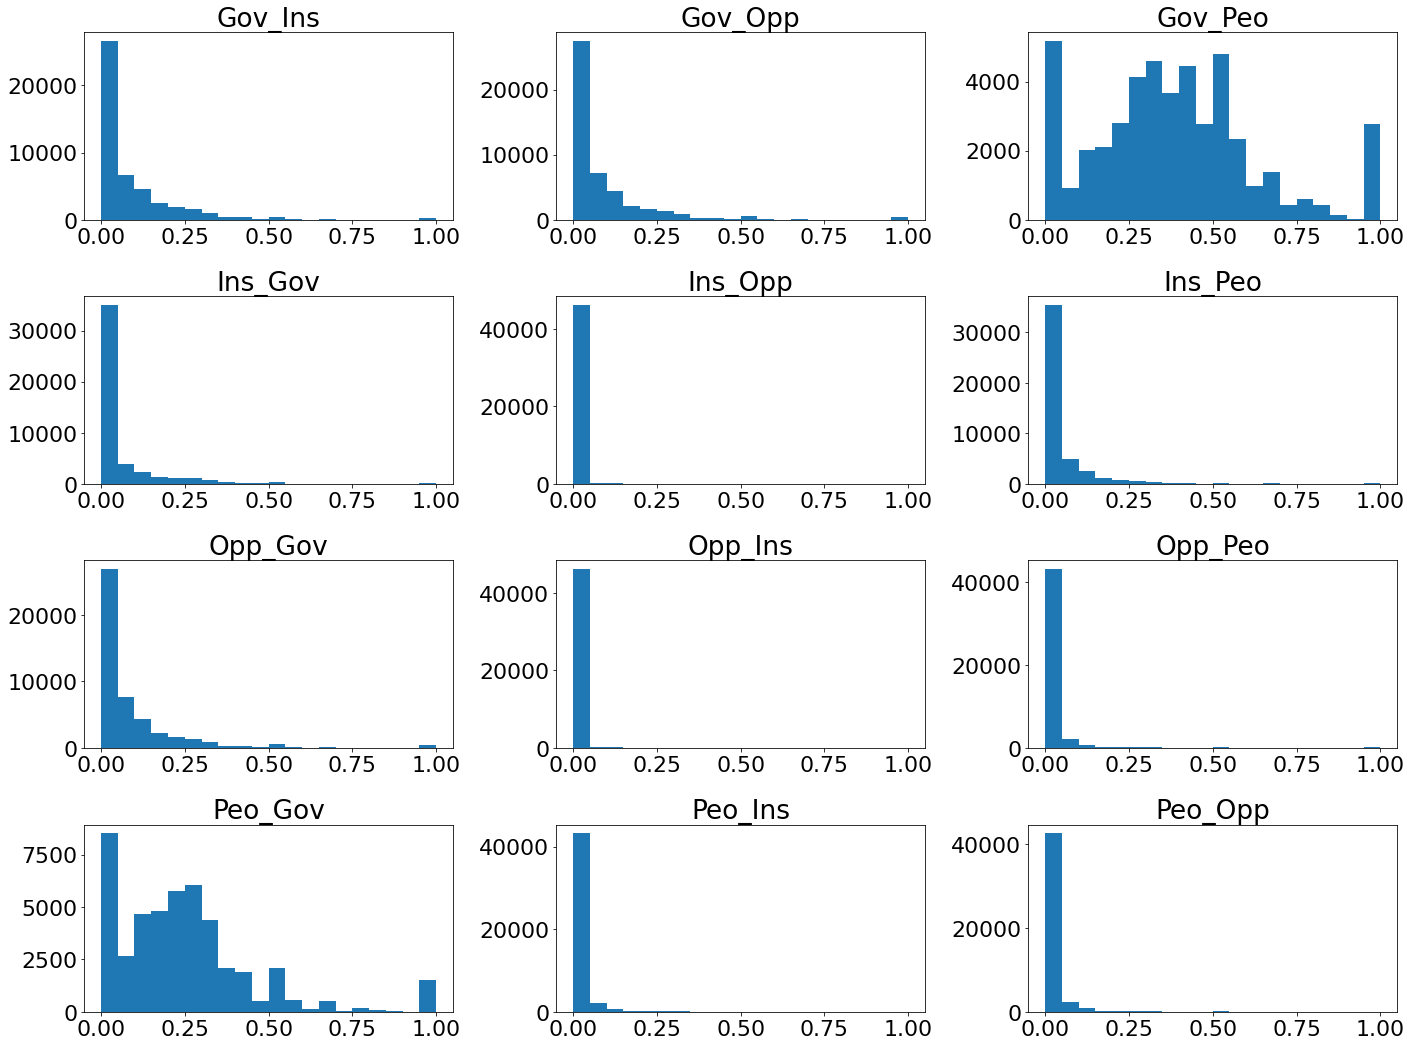

In [40]:
fig, axes = plt.subplots(ncols = 3, nrows = 4, figsize = (20,15))
cols_loop = [["Gov_Ins", "Gov_Opp", "Gov_Peo"], ["Ins_Gov", "Ins_Opp", "Ins_Peo"], 
           ["Opp_Gov", "Opp_Ins", "Opp_Peo"], ["Peo_Gov", "Peo_Ins", "Peo_Opp"]]
for i in range(0, 4):
    for j in range(0,3):
        axes[i,j].hist(model_filtered[cols_loop[i][j]], bins = 20)
        axes[i,j].set_title(cols_loop[i][j])
fig.tight_layout()

### 2.1.1. Differences between cases
We want to compare cases where a civil war starts where case where it does not, and cases where a civil war ends with cases were it continues. 

In [41]:
no_civil_war = model_filtered[model_filtered["CW_plus1"]=="000"]
civil_war_starts = model_filtered[model_filtered["CW_plus1"]=="100"]
civil_war_finishes = model_filtered[model_filtered["CW_plus1"]=="010"]
civil_war_ongoing = model_filtered[model_filtered["CW_plus1"]=="001"]

As a first approach we can take a look at the means of each column:

In [42]:
cols = ["Gov_Ins", "Gov_Opp", "Gov_Peo", "Ins_Gov", "Ins_Opp", "Ins_Peo", 
           "Opp_Gov", "Opp_Ins", "Opp_Peo", "Peo_Gov", "Peo_Ins", "Peo_Opp"]
mean_values = pd.DataFrame(index = ["000", "100", "010", "001"], columns = cols)
mean_values.loc["000",:] = no_civil_war[cols].mean().round(4)
mean_values.loc["100",:] = civil_war_starts[cols].mean().round(4)
mean_values.loc["010",:] = civil_war_finishes[cols].mean().round(4)
mean_values.loc["001",:] = civil_war_ongoing[cols].mean().round(4)
mean_values

,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
000,0.0655,0.0803,0.406,0.0308,0.0014,0.0311,0.0813,0.0014,0.0158,0.2577,0.0117,0.017
100,0.0795,0.1139,0.3414,0.0751,0.0013,0.0269,0.097,0.0065,0.0228,0.2134,0.0068,0.0155
010,0.1672,0.0742,0.2204,0.1204,0.0032,0.0774,0.0617,0.0024,0.0092,0.2252,0.0202,0.0185
001,0.1607,0.0542,0.2621,0.1471,0.0037,0.0948,0.0575,0.0032,0.0099,0.1727,0.024,0.01


Some slightly differences can be seen between the means for each case, however, that does not mean that they are statistically significant. 

In [43]:
pvalues_snw = []
for i in range(0, len(cols)):
    a = no_civil_war[cols[i]]
    b = civil_war_starts[cols[i]]
    pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
    pvalues_snw.append((cols[i], pvalue))
pd.DataFrame(pvalues_snw).set_index(0).sort_values(1).transpose()

,Ins_Gov,Peo_Gov,Gov_Peo,Peo_Ins,Gov_Opp,Opp_Ins,Gov_Ins,Opp_Gov,Opp_Peo,Ins_Peo,Peo_Opp,Ins_Opp
1,0.08139,0.106913,0.107398,0.127057,0.280774,0.362587,0.409302,0.457827,0.475894,0.692849,0.768846,0.807861


We see that the smallest p-value is for the column that represents when Insurgents are the source and Government is the target. For that columns the means were:

In [44]:
mean_values.loc[["000","100"],["Ins_Gov"]].transpose()

,000,100
Ins_Gov,0.0308,0.0751


So the number of events where Insurgents are the source and Government is the target increase. Although, this differences are not statistically significant, it is good to ask how do they increase? Is it because they become allies or because they become enemies? The logic suggest the latter, however this model does not provide enough information to support this. 

Doing the same for ongoingness and ending of a civil war:

In [45]:
pvalues_of = []
for i in range(0, len(cols)):
    a = civil_war_finishes[cols[i]]
    b = civil_war_ongoing[cols[i]]
    pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
    pvalues_of.append((cols[i], pvalue))
pd.DataFrame(pvalues_of).set_index(0).sort_values(1).transpose()

,Peo_Gov,Gov_Peo,Ins_Gov,Ins_Peo,Peo_Ins,Peo_Opp,Gov_Opp,Opp_Ins,Ins_Opp,Opp_Gov,Gov_Ins,Opp_Peo
1,0.129243,0.157433,0.203523,0.343126,0.353074,0.388165,0.409561,0.513938,0.76336,0.802144,0.841175,0.857689


This time all p-values are above 0.1, so the differences between the means are not statistically significant, with the lowest p-value being for actions taken by the Government that targeted People. 

However, this does not mean this model is not good for the purposes of this project. 

### 2.1.2. Principal component analysis 
Principal component analysis is used to collect information about the model a provide a simple visualization using its fisrt two components. 

In [46]:
cols = ["Gov_Ins", "Gov_Opp", "Gov_Peo", "Ins_Gov", "Ins_Opp", "Ins_Peo", 
           "Opp_Gov", "Opp_Ins", "Opp_Peo", "Peo_Gov", "Peo_Ins", "Peo_Opp"]
data = model_filtered[cols]

# Standardize
ss = StandardScaler()
data = ss.fit_transform(data)

In [47]:
pca = PCA(2)
pca.fit(data)

PCA(n_components=2)

In [48]:
pca.explained_variance_ratio_

array([0.15244824, 0.1259631 ])

The first two components explain about 24% of the variation of the data. Each predictor should explain about 8% of the variation of the data (there are 12 predictors so 100/12~8), so the first two principal components explain results slightly better than the original model. 

Visualising the data using those two components the following plot is generated:

In [49]:
data_transformed = pca.transform(data)

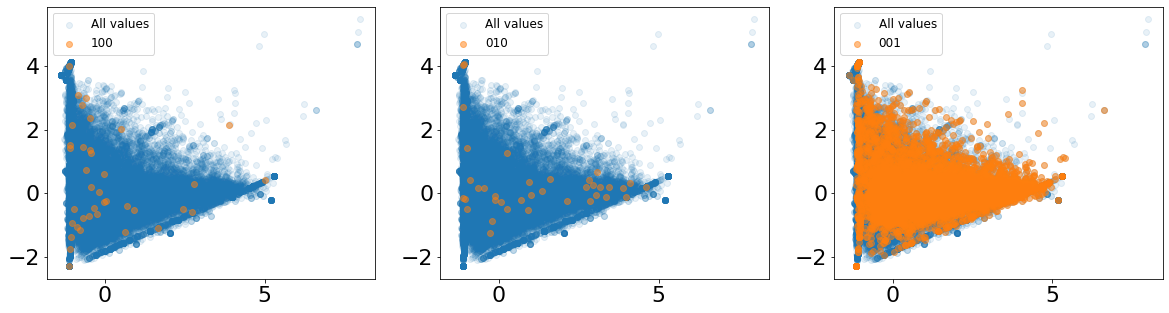

In [51]:
f, ax = plt.subplots(ncols = 3, figsize = (20,5))
ax[0].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[0].scatter(data_transformed[model_filtered["CW_plus1"]=="100",0], 
            data_transformed[model_filtered["CW_plus1"]=="100",1], alpha = 0.5)
ax[0].legend(["All values", "100"], prop={'size': 12})
ax[1].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[1].scatter(data_transformed[model_filtered["CW_plus1"]=="010",0], 
            data_transformed[model_filtered["CW_plus1"]=="010",1], alpha = 0.5)
ax[1].legend(["All values", "010"], prop={'size': 12})
ax[2].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[2].scatter(data_transformed[model_filtered["CW_plus1"]=="001",0], 
            data_transformed[model_filtered["CW_plus1"]=="001",1], alpha = 0.5)
ax[2].legend(["All values", "001"], prop={'size': 12})

The plot is fan-shaped. Starting civil wars are distributed more vertically, suggesting that the first principal component separates those values from the rest. Ending civil wars are distributed more horizontally, suggesting that the second component separates those cases best. Ongoing civil wars are evenly distributed throught the whole distribution. 

Therefore, it is useful to see how each of the predictors contribute to each component:

In [54]:
components = pd.DataFrame(pca.components_).transpose()
sorted_cols = components[0].abs().sort_values(ascending = False).index
[(cols[i], components.iloc[i,0]) for i in sorted_cols][:3]

[('Ins_Gov', 0.5382158660533164),
 ('Gov_Ins', 0.5035860444546466),
 ('Ins_Peo', 0.40832507498936654)]

In [53]:
sorted_cols = components[1].abs().sort_values(ascending = False).index
[(cols[i], components.iloc[i,1]) for i in sorted_cols][:3]

[('Gov_Peo', -0.6384496646254637),
 ('Opp_Gov', 0.5145851396078135),
 ('Gov_Opp', 0.4925237705338385)]

The first component heavily relies on Insurgents and the interaction between them and Government. This is the same result obtained when evaluating the diferences between means in the previous section for starting civl wars, where this predictor had a relatively low p-value. 

The second component studies interactions between Government and Opposition and also actions taken by the Government to People. Simmilar to what was obtained for differences between means between ending and ongoingness of a civil war in the previous section. 

This suggests that, although p-values are very low, the *Interaction Fraction* model is able to detect certain key predictors for the purposes of this project. 

### 2.1.3. Training the model
Random forests are good at handling noisy data and outliers. However, monthly aggregations with no events at all will be removed for training purposes. The data will be splitted in training and testig sets at the beginning of 2004. Rows without events will be removed too:

In [379]:
date_filter = "2004-01"

Xtrain = interaction_fraction[interaction_fraction["Year_Month"]>=date_filter][cols]
ytrain = interaction_fraction[interaction_fraction["Year_Month"]>=date_filter].iloc[:,-1]

Xtest = interaction_fraction[interaction_fraction["Year_Month"]<date_filter][cols]
ytest = interaction_fraction[interaction_fraction["Year_Month"]<date_filter].iloc[:,-1]

In [380]:
# Removing empty data
indexes = (Xtrain.T != 0).any()
Xtrain_cleaned = Xtrain.loc[indexes,:]
ytrain_cleaned = ytrain.loc[indexes]

10000 trees will be used to better handle noise and each tree of the forest is set to have no more than 4 leaf nodes to reduce the size of the tree, preventing overfitting in each weak learner. 

In [431]:
rf = RandomForestClassifier(random_state = 1492, n_estimators = 10000, oob_score = True,
                               criterion = "entropy", max_leaf_nodes=4)
rf.fit(Xtrain_cleaned, ytrain_cleaned)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=4,
                       n_estimators=10000, oob_score=True, random_state=1492)

In [432]:
ytrain_score = rf.oob_decision_function_

In [433]:
classes = rf.classes_
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytrain_cleaned==classes[i], ytrain_score[:,i]))

000 : 0.9119562735869504
001 : 0.9131226505354174
010 : 0.6778269785134775
100 : 0.6147045190204949


Due to the imbalance of the data (cases are almost always "000"), it is not surprising that the model works well for those classes (AUC score over 0.9). The model also works well at predicting ongoingness of the conflict ("001"), with a high AUC score (over 0.9). For ending civil wars ("010") the AUC score is also relatively high, being better that a random classifier (with an AUC of 0.5). The same case applies when predicting starting civil wars ("100"). 

In [434]:
ypred = rf.predict_proba(Xtest)

In [435]:
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytest==classes[i], ypred[:,i]))

000 : 0.8687215145342613
001 : 0.8712529109847383
010 : 0.6978355368460802
100 : 0.5982664092664093


Testing set's results are very consistent with the out of bag predictions, suggesting that no overfitting or underfitting is happening. 

One last thing to do with this model is to check if the predictors that appeared with the t-tests and the PCA are relevant to our model:

In [447]:
importance = rf.feature_importances_
importance_list = []

for i in range(0,len(cols)):
    importance_list.append((cols[i], importance[i]))

importance_df = pd.DataFrame(importance_list, columns = ["Predictor","Importance"])

In [451]:
importance_df.sort_values("Importance", ascending = False).transpose()

,3,5,10,0,4,2,7,9,6,8,1,11
Predictor,Ins_Gov,Ins_Peo,Peo_Ins,Gov_Ins,Ins_Opp,Gov_Peo,Opp_Ins,Peo_Gov,Opp_Gov,Opp_Peo,Gov_Opp,Peo_Opp
Importance,0.336304,0.182119,0.170992,0.114179,0.0725058,0.054836,0.0384296,0.0168433,0.00979442,0.0025303,0.0011806,0.000285607


As shown in the section where the t-tests were made, and in the principal component section, Insurgents play a key rol determining civil wars. 

## 2.2. Mean intensity model
One of the problems with the previous model was that there was no way to see if the interaction was positive or negative. If more interaction meant cooperation or attacks. This model aims to solve those problems. 

This model uses the *"Intensity"* column from the ICEWS datasets and returns the mean value for each month and for each interaction type. For example, looking at data from 2017:

In [454]:
year_2017_iso3.drop(["Country"], axis = 1)
year_2017_iso3.head(1)

,ISO3,Year_Month,CAMEO,Intensity,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
2,BDI,2017-01,193,-10.0,0,0,0,1,0,0,0,0,0,0,0,0


This is just one event, now its intensity will be stored in the interaction column:

In [458]:
mean_intensity_2017 = year_2017_iso3.loc[:,["ISO3","Year_Month"]]
for col in cols:
    mean_intensity_2017.loc[:,col] = year_2017_iso3.loc[:,col]*year_2017_iso3.loc[:,"Intensity"]
mean_intensity_2017.head(1)    

,ISO3,Year_Month,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
2,BDI,2017-01,-0.0,-0.0,-0.0,-10.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


Then results are averaged for each month: 

In [462]:
mean_intensity_2017.groupby(["ISO3","Year_Month"]).mean().loc["BDI","2017-01",:]

,,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
ISO3,Year_Month,,,,,,,,,,,,
BDI,2017-01,0.0,0.0,-0.794595,-3.648649,0.0,-0.513514,0.081081,0.0,0.0,-0.432432,0.0,0.0


The model is generated using the <code>mean_intensity</code> 